# Alignment Error

This notebook collects COM data from the database and tries to quantify some alignment errors. The main results are shown in the plots at the end of the notebook.

In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import func

sns.set_style("whitegrid")

In [3]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.model.center_of_mass import CenterOfMass
from utilities.model.structure import Structure
from sql_setup import session

## Data Collection

In [4]:
def query_brain_coms(brain, person_id=28):
    # person_id = 1 is Ed
    # person_id = 28 is Bili
    prep_id = brain
    input_type = 'aligned'

    rows = session.query(CenterOfMass)\
        .filter(CenterOfMass.active.is_(True))\
        .filter(CenterOfMass.prep_id == prep_id)\
        .filter(CenterOfMass.person_id == person_id)\
        .filter(CenterOfMass.input_type == input_type)\
        .all()

    row_dict = {}
    for row in rows:
        structure = row.structure.abbreviation
        row_dict[structure] = np.array([row.x, row.y, row.section])
    return row_dict

In [5]:
from utilities.sqlcontroller import SqlController

def get_atlas_centers(
        atlas_box_size=(1000, 1000, 300),
        atlas_box_scales=(10, 10, 20),
        atlas_raw_scale=10
):
    atlas_box_scales = np.array(atlas_box_scales)
    atlas_box_size = np.array(atlas_box_size)
    atlas_box_center = atlas_box_size / 2
    sqlController = SqlController('Atlas')
    atlas_centers = sqlController.get_centers_dict('Atlas', input_type='manual', person_id=16)

    for structure, center in atlas_centers.items():
        # transform into the atlas box coordinates that neuroglancer assumes
        center = atlas_box_center + np.array(center) * atlas_raw_scale / atlas_box_scales
        atlas_centers[structure] = center

    return atlas_centers

atlas_coms = get_atlas_centers()

No histology for Atlas
No scan run for Atlas


In [6]:
def prepare_table_for_save(brains, person_id):
    structures = set()
    for brain in ['DK39', 'DK41', 'DK43', 'DK54', 'DK55']:
        structures = structures | set(query_brain_coms(brain).keys())
    structures = list(sorted(structures))

    brain_coms = {}
    for brain in brains:
        brain_coms[brain] = query_brain_coms(brain, person_id=person_id)
    
    data = {}
    data['name'] = []
    for s in structures:
        for c in ['dx', 'dy', 'dz', 'dist']:
            data['name'] += [f'{s}_{c}']
    for brain in brain_coms.keys():
        data[brain] = []
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)
        for dx_i, dy_i, dz_i, dist_i in zip(dx, dy, dz, dist):
            data[brain] += [dx_i, dy_i, dz_i, dist_i]
    df = pd.DataFrame(data)

    return df

def prepare_table_for_plot(brains, person_id):
    structures = set()
    for brain in ['DK39', 'DK41', 'DK43', 'DK54', 'DK55']:
        structures = structures | set(query_brain_coms(brain).keys())
    structures = list(sorted(structures))

    brain_coms = {}
    for brain in brains:
        brain_coms[brain] = query_brain_coms(brain, person_id=person_id)
    
    df = pd.DataFrame()
    for brain in brain_coms.keys():
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)

        df_brain = pd.DataFrame()

        data = {}
        data['structure'] = structures
        data['value'] = dx
        data['type'] = 'dx'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dy
        data['type'] = 'dy'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dz
        data['type'] = 'dz'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = structures
        data['value'] = dist
        data['type'] = 'dist'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        df_brain['brain'] = brain
        df = df.append(df_brain, ignore_index=True)
    return df

## Rigid Alignment Error

Rigid alignment error is computed as follows:
1. Anotomist manually annotate the COMs for each brain.
2. Computer finds the best transformation between atlas COMs and **anotomist's manual COMs**. The transformation is restricted to rigid + uniform scaling.
3. Using the transformation, the **anotomist's manual COMs** are brought to the atlas space.
4. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [7]:
df_rigid_save = prepare_table_for_save(
    ['DK39', 'DK41', 'DK43', 'DK52', 'DK54', 'DK55'],
    person_id=28
)
df_rigid_save.to_csv('../data/rigid-alignment-error.csv', index=False)
df_rigid_save.head()

,name,DK39,DK41,DK43,DK52,DK54,DK55
0,10N_L_dx,-886.170000,-226.890000,-922.300000,-347.720000,-442.820000,-376.260000
1,10N_L_dy,346.284000,-471.536000,556.474000,-303.826000,-576.846000,-440.396000
2,10N_L_dz,-807.226000,163.016000,-833.546000,-107.584000,-21.504000,253.496000
3,10N_L_dist,1247.727411,548.087117,1362.020388,474.124197,727.532324,632.281936
4,10N_R_dx,-339.800000,-910.780000,-202.500000,-321.520000,-458.250000,-988.280000


In [8]:
df_rigid = prepare_table_for_plot(
    ['DK39', 'DK41', 'DK43', 'DK52', 'DK54', 'DK55'],
    person_id=28
)

### Full dynamic range

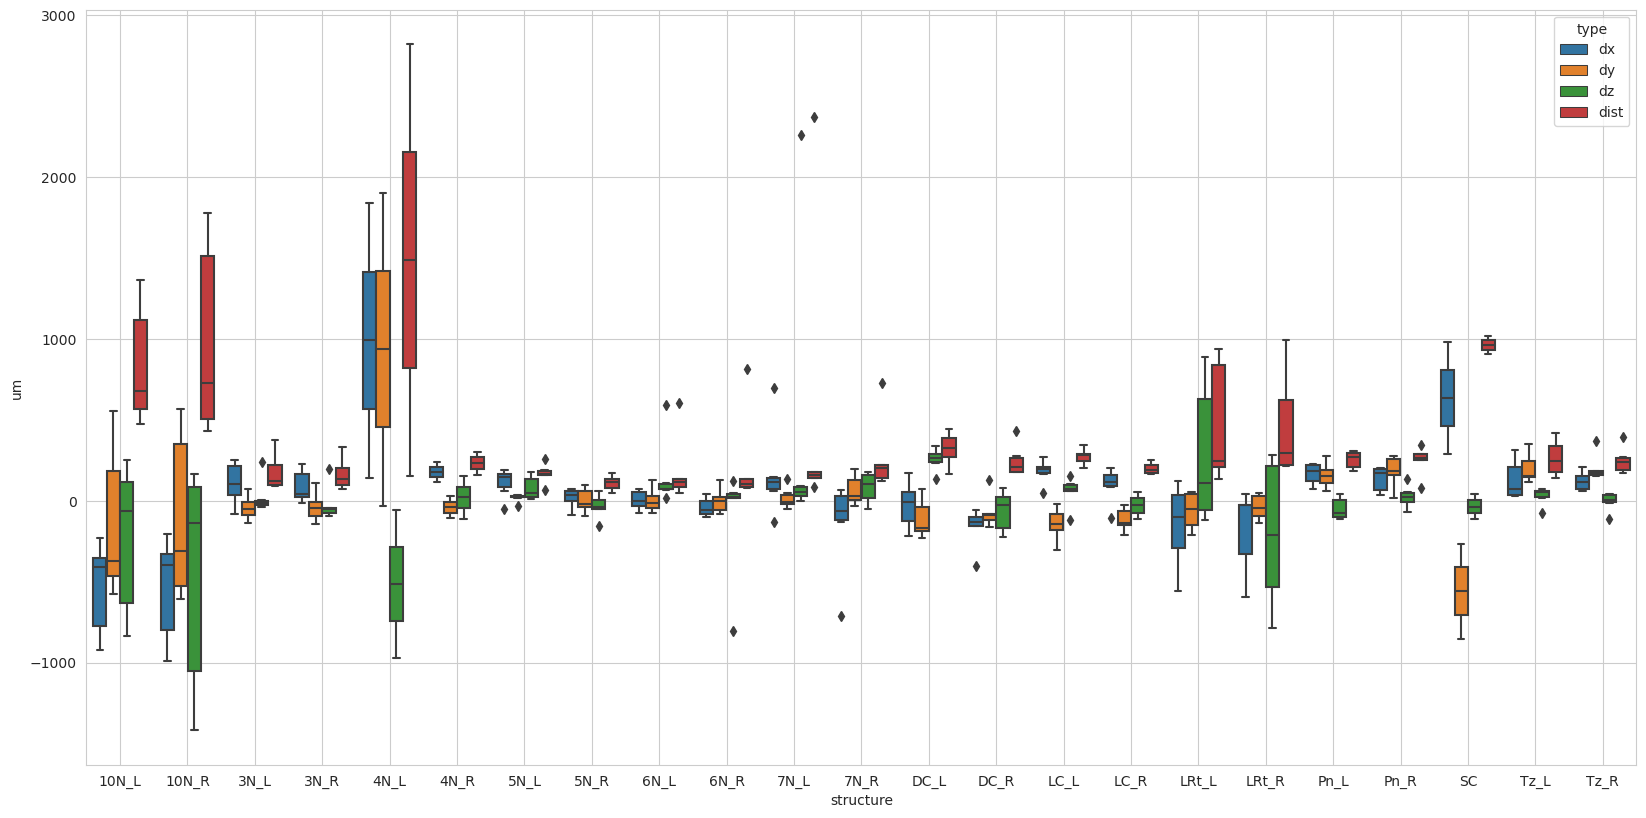

In [9]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rigid)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.show()

### Zoom in

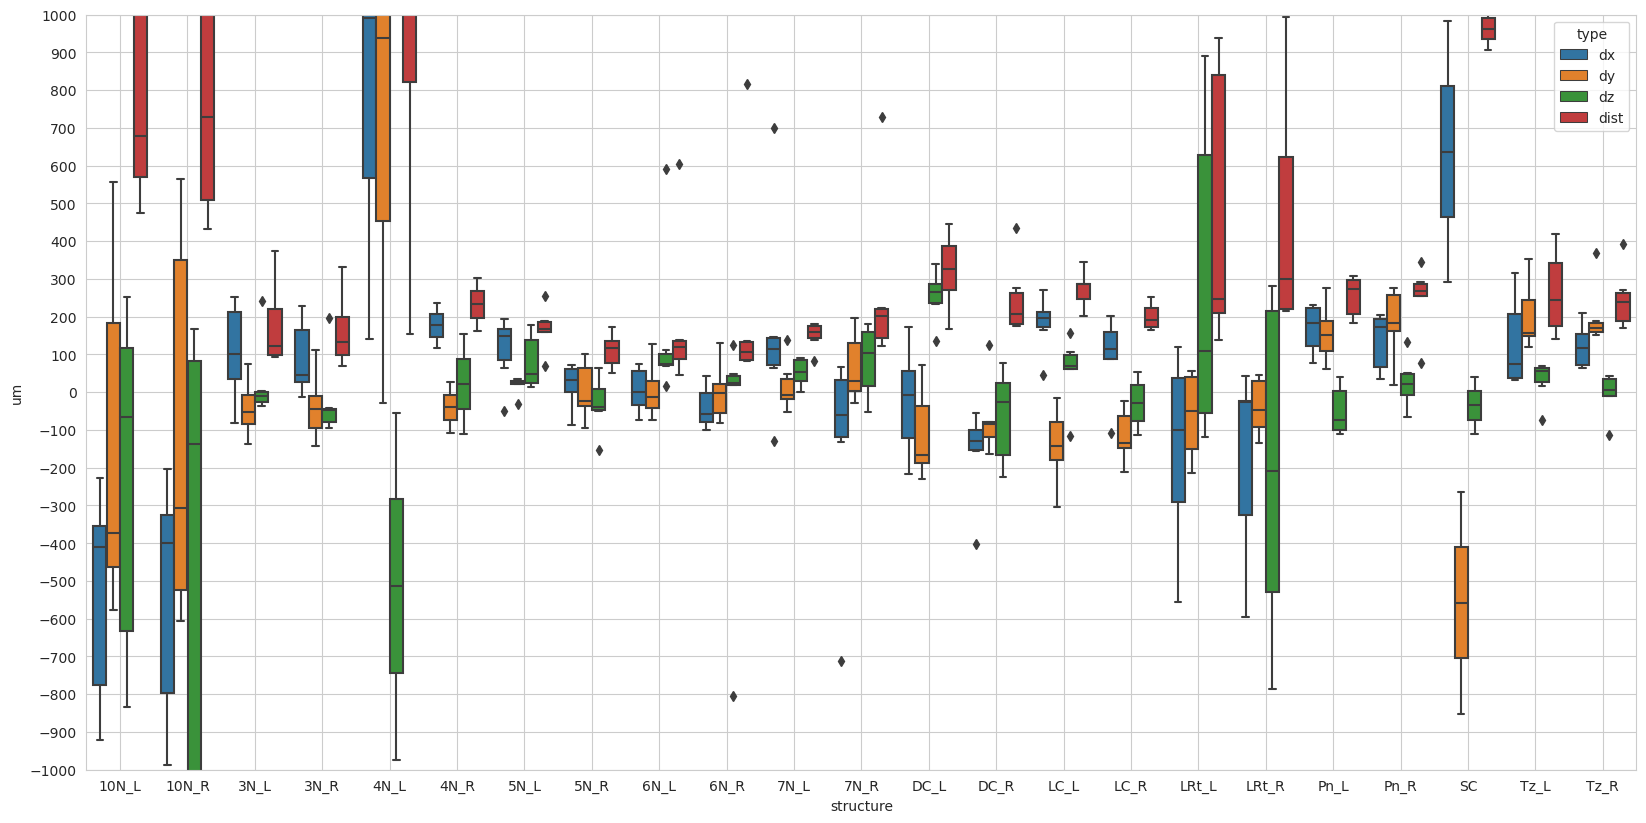

In [10]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rigid)
ax.xaxis.grid(True)
ymin, ymax = -1000, 1000
ax.yaxis.set_ticks(np.arange(ymin, ymax + 1, 100))
plt.ylabel('um')
plt.ylim(ymin, ymax)
plt.show()

## Rough Alignment

Rough alignment is an **automatic method** to find the best 3D affine transformation between 2 brains, solely based on the thumbnail-resolution gray value images. Rough alignment is planned to be the first step of an automatic pipeline, which defines the starting points for Kui's automatic detection method.

## Rough Alignment Error

We start with an anotomist manually annotate the COMs extensively for one brain (DK52).

Rough alignment error is computed as follows:
1. Computer finds the best 3D affine transformation between DK52 and the brain, as determined by aligning the gray value images.
2. Using the transformation, the DK52 COMs are brought to that brain's space. And we call it the **rough COMs** of the brain.
3. Computer finds the best transformation between atlas COMs and **rough COMs**. The transformation is restricted to rigid + uniform scaling.
4. Using the transformation, the **rough COMs** are brought to the atlas space.
5. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [11]:
df_rough_save = prepare_table_for_save(
    ['DK39', 'DK41', 'DK43', 'DK54', 'DK55'],
    person_id=1
)
df_rough_save.to_csv('../data/rough-alignment-error.csv', index=False)
df_rough_save.head()

,name,DK39,DK41,DK43,DK54,DK55
0,10N_L_dx,-348.050000,212.630000,-648.20000,-418.430000,NaN
1,10N_L_dy,-1940.336000,-1430.836000,-1635.79600,-1034.106000,NaN
2,10N_L_dz,-412.664000,470.656000,-155.58400,19.436000,NaN
3,10N_L_dist,2014.034303,1521.190404,1766.40827,1115.722475,NaN
4,10N_R_dx,712.030000,515.200000,-132.22000,22.640000,NaN


In [12]:
df_rough = prepare_table_for_plot(
    ['DK39', 'DK41', 'DK43', 'DK54', 'DK55'],
    person_id=1
)

### Full dynamic range

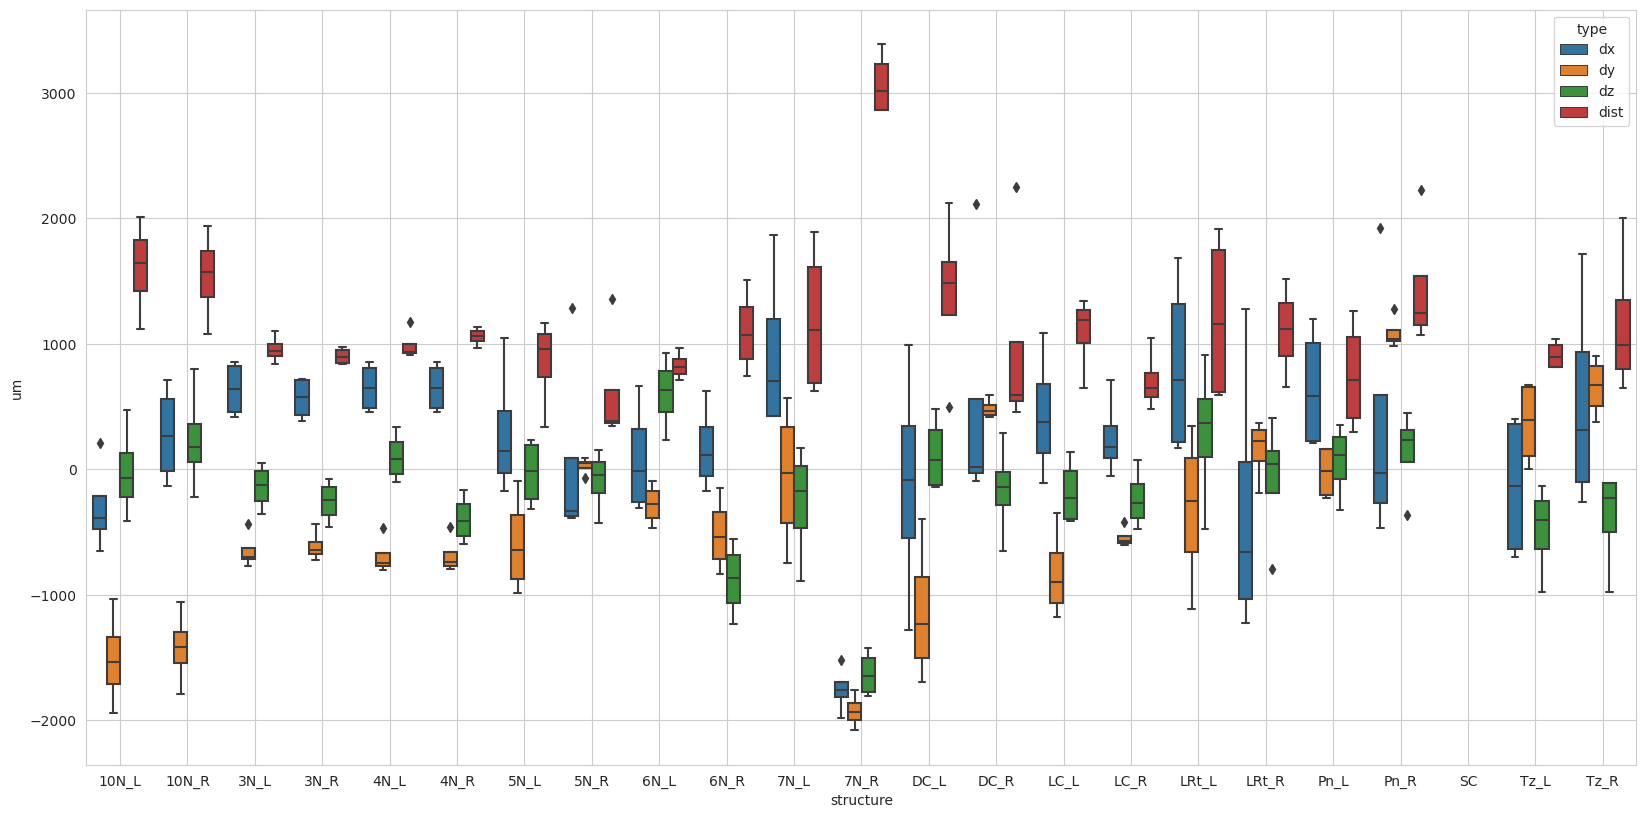

In [13]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rough)
ax.xaxis.grid(True)
plt.ylabel('um')
plt.show()

### Zoom in

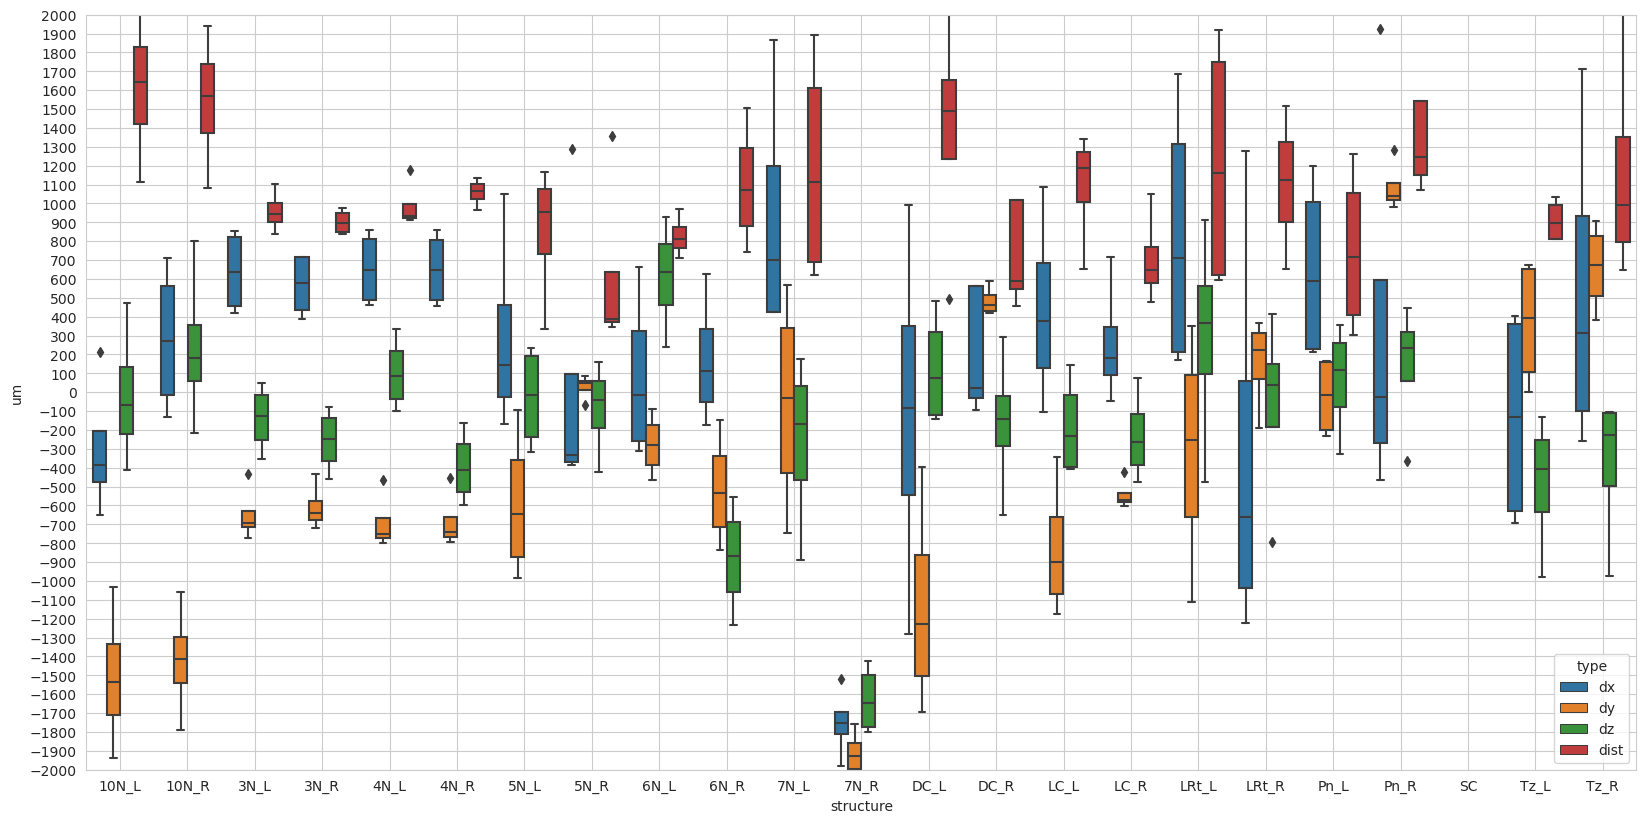

In [14]:
plt.figure(figsize=(20, 10), dpi=100)
ax = sns.boxplot(x="structure", y="value", hue="type", data=df_rough)
ax.xaxis.grid(True)
ymin, ymax = -2000, 2000
ax.yaxis.set_ticks(np.arange(ymin, ymax + 1, 100))
plt.ylabel('um')
plt.ylim(ymin, ymax)
plt.show()